In [1]:
import pandas as pd
from bs4 import BeautifulSoup
from tqdm import tqdm
import base64

tqdm.pandas()
from wekeypedia import WikipediaPage as Page

In [2]:
name = 'Chelsea Manning'
dead_name = b'QnJhZGxleQ=='

# qui sont personnes qui énoncent le deadname dans l'article ?

## article

In [3]:
page = Page('Chelsea_Manning', lang='fr')

In [4]:
revisions = (
    pd
    .DataFrame
    .from_records(page.get_revisions())
    .set_index('revid')
)

revisions

,parentid,user,userid,timestamp,size,sha1,contentformat,contentmodel,comment,*,anon
revid,,,,,,,,,,,
213078305,213074072,Cymbella,316223,2024-03-05T13:35:19Z,65080,d04ef73a4963672590b9abbc80020d18c74cc1dc,text/x-wiki,wikitext,/* Retour aux États-Unis */ style,{{homon|Manning}}\n{{Nom protégé}}\n{{Infobox ...,NaN
213074072,213073964,Chouette bougonne,4364626,2024-03-05T10:51:07Z,65092,43d85c1b04a6ae3fc2edc14de66e944f20eff16f,text/x-wiki,wikitext,Annulation de la [[Special:Diff/213073964|modi...,{{homon|Manning}}\n{{Nom protégé}}\n{{Infobox ...,NaN
213073964,213073846,Nattes à chat,1372207,2024-03-05T10:47:17Z,65136,8f7278cdad94fda6a4f2793564384ad5a6c97131,text/x-wiki,wikitext,Ajout de {{[[Modèle:Désaccord de pertinence|Dé...,{{Désaccord de pertinence|date=mars 2024}}\n{{...,NaN
213073846,213073767,Chouette bougonne,4364626,2024-03-05T10:43:25Z,65092,43d85c1b04a6ae3fc2edc14de66e944f20eff16f,text/x-wiki,wikitext,Annulation de la [[Special:Diff/213073767|modi...,{{homon|Manning}}\n{{Nom protégé}}\n{{Infobox ...,NaN
213073767,213070331,Nattes à chat,1372207,2024-03-05T10:40:57Z,65130,0078220eb8337292b9609f41db561956389c40ad,text/x-wiki,wikitext,Ajout de {{[[Modèle:Article non neutre|Article...,{{Article non neutre|date=mars 2024}}\n{{homon...,NaN
...,...,...,...,...,...,...,...,...,...,...,...
55885071,55855880,82.234.40.89,0,2010-08-05T20:06:06Z,3209,268905c1fab752a4753f263f7b687d9bedc1c411,text/x-wiki,wikitext,,'''Bradley Manning''' (né en 1987) est un anna...,
55855880,55774595,Luckas-bot,414968,2010-08-04T20:07:22Z,3205,a5648276e079e211eb19dbd0a985d04c55f6dd59,text/x-wiki,wikitext,robot Ajoute: [[es:Bradley Manning]],'''Bradley Manning''' (né en 1987) est un anna...,NaN
55774595,55774530,84.164.59.139,0,2010-08-02T09:43:44Z,3182,3367b7c2dbb06761ea755ec510ffe74ec932014d,text/x-wiki,wikitext,création de la page depuis la version englaise...,'''Bradley Manning''' (né en 1987) est un anna...,


In [5]:
revisions.to_csv('../data/page-revisions/chelsea_manning.csv')

In [6]:
def decode(string):
    return base64.b64decode(string).decode("utf-8")

<Axes: xlabel='date'>

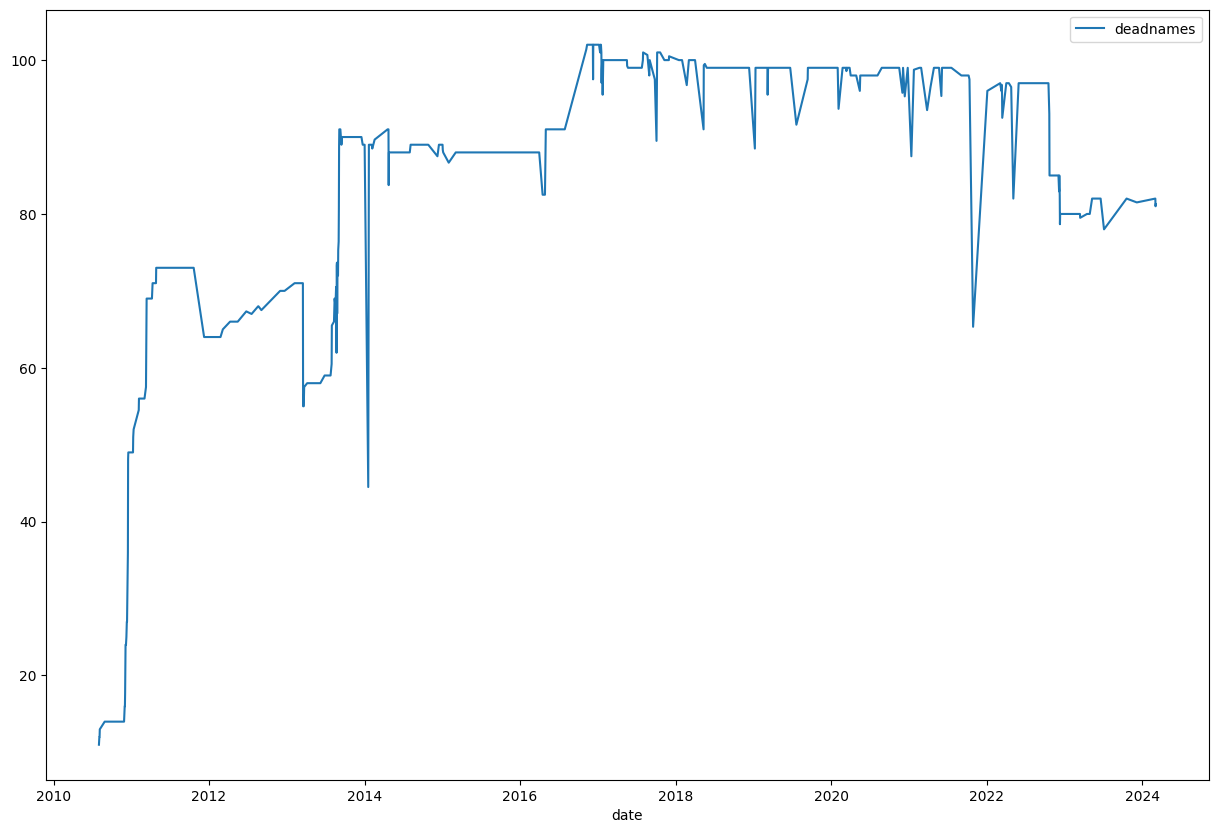

In [7]:
(
    revisions
    .assign(
        deadnames = lambda df: df['*'].apply(lambda x: x.lower().count(decode(dead_name).lower()))
    )
    #.reset_index()
    [['timestamp', 'deadnames']]
    .assign(
        date = lambda df: pd.to_datetime(df.timestamp).dt.date
    )
    .groupby('date')
    .agg({'deadnames': 'mean'})
    .plot
    .line(
        figsize=(15,10)
    )
)

In [8]:
def get_diff(revid):
    return page.get_diff(revid)

diffs = revisions.reset_index().revid.progress_apply(lambda x: page.extract_plusminus(get_diff(x))['added'] )

#diffs

100%|████████████████████████████████████████████████████████████████████| 1060/1060 [05:42<00:00,  3.10it/s]


### depuis le coming out

In [19]:
(
    revisions
    .assign(
        deadname_count = [ ' '.join(added).lower().count(decode(dead_name).lower()) for added in diffs ]
    )
    # on ne garde que les contributions après son coming out
    .query('timestamp >= "2013-08-22"')
    .groupby('user')
    .deadname_count
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

user
Sebk                 129
Malaria28            115
Skouratov             97
Mattho69              89
Chouette bougonne     58
Julien1978            40
Shev123               34
Hégésippe Cormier     31
Lebob                 30
Super Bazooka         23
Name: deadname_count, dtype: int64

### depuis le début du sondage

In [16]:
(
    revisions
    .assign(
        deadname_count = [ ' '.join(added).lower().count(decode(dead_name).lower()) for added in diffs ]
    )
    # début du sondage
    .query('timestamp >= "2024-02-12"')
    .groupby('user')
    .deadname_count
    .sum()
    .sort_values(ascending=False)
    .head(20)
)

user
Sherwood6                     12
Triboulet sur une montagne     6
Anne Daemon                    0
Chouette bougonne              0
Cymbella                       0
Evpok                          0
Nattes à chat                  0
Name: deadname_count, dtype: int64

## Discussions

In [11]:
talk = Page('Discussion:Chelsea_Manning', lang='fr')

In [12]:
talk_revisions = (
    pd
    .DataFrame
    .from_records(talk.get_revisions_list())
    .assign(
        diff = lambda df: df.revid.progress_apply(lambda x: talk.get_diff(x)),
        deleted = lambda df: df['diff'].apply(lambda diff: talk.extract_plusminus(diff)['deleted']),
        added = lambda df: df['diff'].apply(lambda diff: talk.extract_plusminus(diff)['added']),
    )
    .set_index('revid')
)

#talk_revisions

100%|██████████████████████████████████████████████████████████████████████| 534/534 [02:45<00:00,  3.24it/s]


In [13]:
talk_revisions.to_csv('../data/page-diffs/discussion:chelsea_manning.csv')

### depuis le coming out

In [17]:
(
    talk_revisions
    .assign(
        deadname_count = lambda df: df.added.apply(lambda x: ' '.join(x).lower().count(decode(dead_name).lower()))
    )
    # on ne garde que les contributions après son coming out
    .query('timestamp >= "2013-08-22"')
    .groupby('user')
    .deadname_count
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

user
Hauru                   33
Jean-Jacques Georges    22
Sherwood6               17
Christophe Dioux        11
Euterpia                 7
Julien1978               7
Ash Crow                 6
Heddryin                 6
Fanchb29                 5
Gaz0line                 4
Name: deadname_count, dtype: int64

### depuis le début du sondage

In [18]:
(
    talk_revisions
    .assign(
        deadname_count = lambda df: df.added.apply(lambda x: ' '.join(x).lower().count(decode(dead_name).lower()))
    )
    # depuis le sondage
    .query('timestamp >= "2024-02-12"')
    .groupby('user')
    .deadname_count
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

user
Sherwood6            17
Anne Daemon           3
Chouette bougonne     1
Lastrik               1
Nattes à chat         1
Cymbella              0
Evpok                 0
Jugio                 0
Lewisiscrazy          0
Pic-Sou               0
Name: deadname_count, dtype: int64